# Data Analysis Covid-19 in North Carolina Counties

In [1]:
# Dependencies
%matplotlib notebook
from census import Census
from config import (census_key, gkey)
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from us import states
from scipy.stats import linregress
from matplotlib import pyplot as plt
from pprint import pprint

# Census API Key
c = Census(census_key)

## Generate Census Data

In [2]:
census_data = c.acs5.get(("NAME", "B01003_001E","B01002_001E", "B19013_001E","B19301_001E","B07013_002E"),
                         {'for': 'county:*','in': 'state:37'})

census_df = pd.DataFrame(census_data)
census_df

census_df = census_df.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B07013_002E": "Householder Owner",
                                      "NAME": "County"})
census_df


# Add in Householder Owner Rate (Hoseholder Owner / Population)
census_df["Householder Owner Rate"] = 100 * \
    census_df["Householder Owner"].astype(
        int) / census_df["Population"].astype(int)

# Final DataFrame
census_df = census_df[["County", "Population", "Median Age", "Household Income", 
                       "Per Capita Income", "Householder Owner Rate", ]]

census_df["County"]= census_df["County"].str.split(",", n = 1, expand = True)

census_df["Population Formatted"] = census_df["Population"].map("{:,.0f}".format)
census_df["Household Income Formatted"] = census_df["Household Income"].map("${:,.2f}".format)
census_df["Per Capita Income Formatted"] = census_df["Per Capita Income"].map("${:,.2f}".format)
census_df["Householder Owner Rate Formatted"] = census_df["Householder Owner Rate"].map("%{:.1f}".format)

census_df['County'] = census_df['County'].str.replace(r'County', '').str.rstrip()
census_df

census_df = census_df.sort_values("County", ascending=True)

census_df = census_df.reset_index(drop=True)

# Visualize
print(len(census_df))
census_df.head()

100


,County,Population,Median Age,Household Income,Per Capita Income,Householder Owner Rate,Population Formatted,Household Income Formatted,Per Capita Income Formatted,Householder Owner Rate Formatted
0,Alamance,157844.0,39.7,44281.0,25157.0,64.182991,"157,844","$44,281.00","$25,157.00",%64.2
1,Alexander,37159.0,42.8,44523.0,22655.0,71.285557,"37,159","$44,523.00","$22,655.00",%71.3
2,Alleghany,10935.0,49.2,38944.0,21153.0,72.812071,"10,935","$38,944.00","$21,153.00",%72.8
3,Anson,25531.0,40.4,38123.0,19105.0,60.937684,"25,531","$38,123.00","$19,105.00",%60.9
4,Ashe,26833.0,47.2,40293.0,23650.0,73.197183,"26,833","$40,293.00","$23,650.00",%73.2


In [3]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   County                            100 non-null    object 
 1   Population                        100 non-null    float64
 2   Median Age                        100 non-null    float64
 3   Household Income                  100 non-null    float64
 4   Per Capita Income                 100 non-null    float64
 5   Householder Owner Rate            100 non-null    float64
 6   Population Formatted              100 non-null    object 
 7   Household Income Formatted        100 non-null    object 
 8   Per Capita Income Formatted       100 non-null    object 
 9   Householder Owner Rate Formatted  100 non-null    object 
dtypes: float64(5), object(5)
memory usage: 7.9+ KB


In [4]:
# Export to csv
census_df.to_csv("Census.csv", index=False, header=True)

## Generate Covid-19 Data

In [7]:
url="https://api.covid19api.com/dayone/country/united-states"
response = requests.get(url).json()
covid_df = pd.DataFrame(response)
covid_df
covid_df = covid_df.loc[(covid_df["Province"] == "North Carolina")]
covid_df

covid_df = covid_df.rename(columns={"City": "County",
                                    "CityCode": "Zipcode",
                                    "Lat": "Latitude",
                                    "Lon": "Longitude",})
                        
# Original DataFrame - to alllow for possible look at first occurance date
original_covid_df = covid_df[["County", "Zipcode", "Latitude", "Longitude", "Confirmed", "Deaths", "Recovered", "Active", "Date"]]                                    
covid_df.to_csv("All_Covid.csv", index=False, header=True)

# Final DataFrame
Max_date = original_covid_df["Date"].max()
covid_df = original_covid_df.loc[(covid_df["Date"] == Max_date)]
covid_df

covid_df = covid_df.sort_values("County", ascending=True)

covid_df = covid_df.reset_index(drop=True)

# Visualize
print(len(covid_df))
covid_df.head()

93


,County,Zipcode,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Date
0,Alamance,37001,36.04,-79.4,58,0,0,0,2020-04-21T00:00:00Z
1,Alexander,37003,35.92,-81.18,4,0,0,0,2020-04-21T00:00:00Z
2,Alleghany,37005,36.49,-81.13,2,0,0,0,2020-04-21T00:00:00Z
3,Anson,37007,34.97,-80.1,19,0,0,0,2020-04-21T00:00:00Z
4,Ashe,37009,36.43,-81.5,4,0,0,0,2020-04-21T00:00:00Z


In [8]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   County     93 non-null     object
 1   Zipcode    93 non-null     object
 2   Latitude   93 non-null     object
 3   Longitude  93 non-null     object
 4   Confirmed  93 non-null     int64 
 5   Deaths     93 non-null     int64 
 6   Recovered  93 non-null     int64 
 7   Active     93 non-null     int64 
 8   Date       93 non-null     object
dtypes: int64(4), object(5)
memory usage: 6.7+ KB


In [9]:
# Export to csv
covid_df.to_csv("Covid.csv", index=False, header=True)

## Merged Data

In [10]:
#covid_df.set_index('County', inplace=True)
#census_df.set_index('County', inplace=True)
#census_df.reset_index(drop=True, inplace=True)
#covid_df.reset_index(drop=True, inplace=True)

In [11]:
#merged_df = pd.merge(census_df, covid_df, left_index=True, right_index=True, how="inner", suffixes=['Census', 'Covid'])
#merged_df.drop('CountyCovid', axis=1)
#merged_df.rename(columns={"CountyCensus" : "County"}, inplace=True)
#merged_df.loc[(merged_df["County"] == "Mecklenburg")].head()
#census_df.loc[(census_df["County"] == "Mecklenburg ")].head()
#merged_df

In [12]:
# Merge the two data sets along County

merged_df = census_df.merge(covid_df, on="County",how="inner")

#merged_data = census_df.update(covid_df)

merged_df.head()

,County,Population,Median Age,Household Income,Per Capita Income,Householder Owner Rate,Population Formatted,Household Income Formatted,Per Capita Income Formatted,Householder Owner Rate Formatted,Zipcode,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Date
0,Alamance,157844.0,39.7,44281.0,25157.0,64.182991,"157,844","$44,281.00","$25,157.00",%64.2,37001,36.04,-79.4,58,0,0,0,2020-04-21T00:00:00Z
1,Alexander,37159.0,42.8,44523.0,22655.0,71.285557,"37,159","$44,523.00","$22,655.00",%71.3,37003,35.92,-81.18,4,0,0,0,2020-04-21T00:00:00Z
2,Alleghany,10935.0,49.2,38944.0,21153.0,72.812071,"10,935","$38,944.00","$21,153.00",%72.8,37005,36.49,-81.13,2,0,0,0,2020-04-21T00:00:00Z
3,Anson,25531.0,40.4,38123.0,19105.0,60.937684,"25,531","$38,123.00","$19,105.00",%60.9,37007,34.97,-80.1,19,0,0,0,2020-04-21T00:00:00Z
4,Ashe,26833.0,47.2,40293.0,23650.0,73.197183,"26,833","$40,293.00","$23,650.00",%73.2,37009,36.43,-81.5,4,0,0,0,2020-04-21T00:00:00Z


In [13]:
merged_df.to_csv("Merged_df.csv", index=False, header=True)

## Plotting Data

In [15]:
confirmed_df = merged_df.loc[(merged_df["Confirmed"] > 0)].sort_values('Population', ascending=True)
#confirmed_df.reset_index(inplace=True)
#print(type(confirmed_df["Population"][0]))
#confirmed_df["Population"] = confirmed_df["Population"].str.replace(",", "").astype(int)


In [16]:
confirmed_df.loc[(merged_df["County"] == "Mecklenburg")].head()

,County,Population,Median Age,Household Income,Per Capita Income,Householder Owner Rate,Population Formatted,Household Income Formatted,Per Capita Income Formatted,Householder Owner Rate Formatted,Zipcode,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Date
54,Mecklenburg,1034290.0,34.9,61695.0,35669.0,57.500798,"1,034,290","$61,695.00","$35,669.00",%57.5,37119,35.24,-80.83,1255,36,0,0,2020-04-21T00:00:00Z


<IPython.core.display.Javascript object>


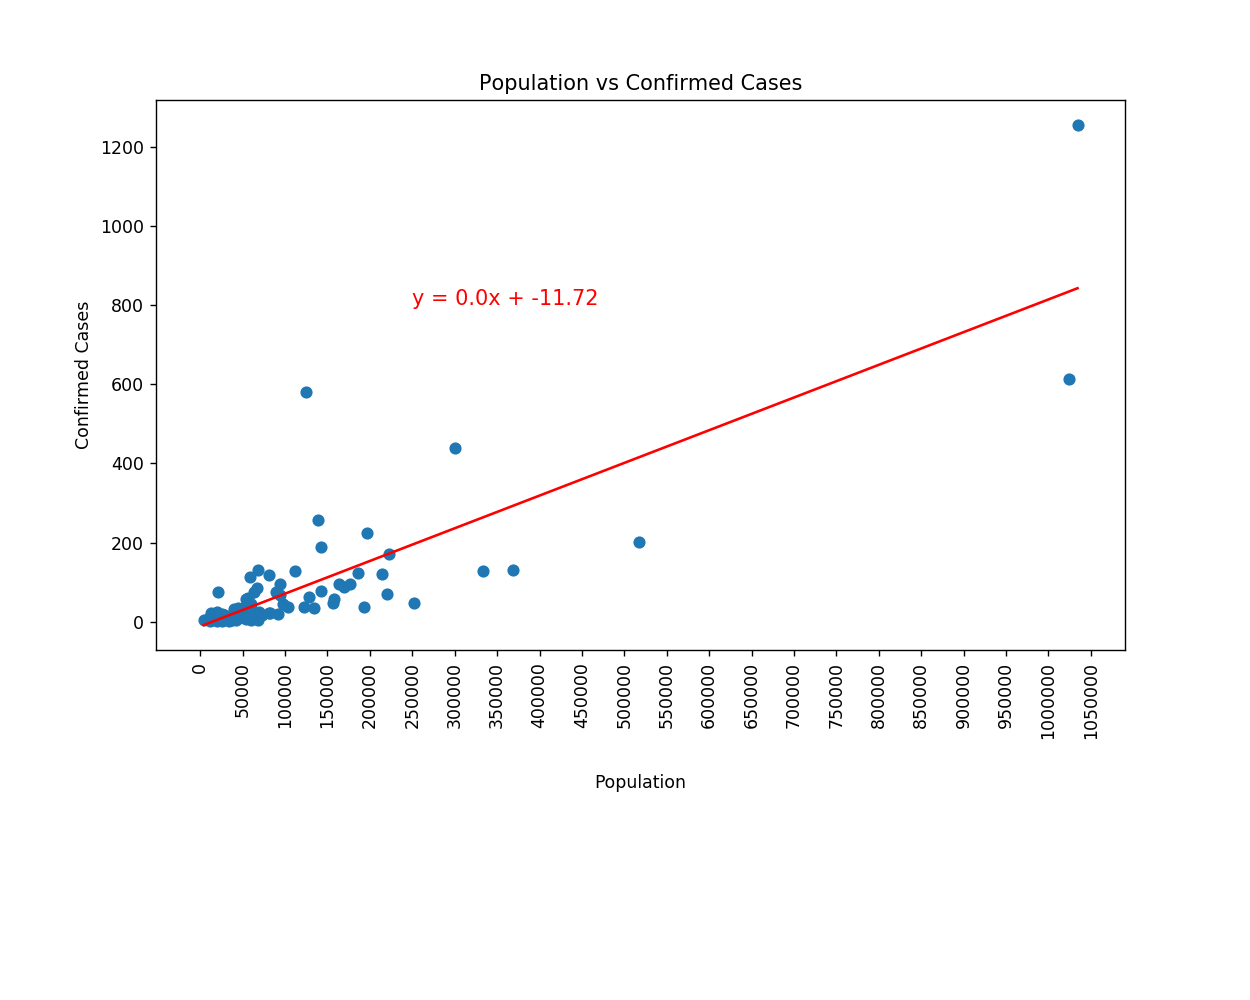

y = 0.0x + -11.72


In [29]:
confirmed_df.sort_values("Population", ascending=True, inplace=True)
confirmed_df = confirmed_df.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10,8))
#xticks = np.arange(confirmed_df["Population"].min(), confirmed_df["Population"].max() + 25000, 50000)
xticks = np.arange(0, confirmed_df["Population"].max() + 25000, 50000)
ax.xaxis.set_ticks(xticks)
plt.scatter(confirmed_df.Population, confirmed_df.Confirmed)
ax.set_xlabel("Population", labelpad=20)
ax.set_ylabel("Confirmed Cases")
ax.set_title("Population vs Confirmed Cases")
plt.xlim = (confirmed_df["Population"].min() -1, confirmed_df["Population"].max() + 1)

fig.subplots_adjust(hspace=0, bottom=.35, top=.9 )
plt.xticks(rotation=90)

(slope, intercept, rvalue, pvalue, stderr) = linregress(confirmed_df["Population"], confirmed_df["Confirmed"])
regress_values = confirmed_df["Population"] * slope + intercept
plt.plot(confirmed_df["Population"],regress_values,"r-")
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)
xplot_loc = 250000
yplot_loc = 800
plt.annotate(line_eq,(xplot_loc,yplot_loc),fontsize=12,color="red")

plt.show()

In [46]:
# Build a scatter plot for each data type

plt.scatter(merged_df['County'], merged_df['Confirmed'], marker="o", edgecolors="black", facecolors="aqua")

# Incorporate de other graph properties
plt.title(f'Confirmed Cases by County % {time.strftime("%m/%d/%Y")}')
plt.ylabel("Confirmed")
plt.xlabel("County")
plt.grid(True)
plt.xlim(0,len('Count'))
plt.ylim(0,1400)

# Save the figure
plt.savefig("ConfirmedCasesbyCounty.png")

# Show plot
plt.show()

TypeError: 'str' object is not callable

In [28]:
# Create a Scatter Plot for temperature vs latitude
x_values = merged_df['County']
y_values = merged_df['Confirmed']
plt.scatter(x_values,y_values)
plt.xlabel('County')
plt.ylabel('Confirmed Cases')
plt.show()